add volume thresholds and only trade when the underlying isn't going exponential against the spread positions Also only run a naive backtest

Error 162, reqId 9: Historical Market Data Service error message:HMDS query returned no data: GOOG  250725C00180000@SMART Trades, contract: Option(conId=789542339, symbol='GOOG', lastTradeDateOrContractMonth='20250725', strike=180.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='GOOG  250725C00180000', tradingClass='GOOG')


No more bars available.


Error 162, reqId 9: Historical Market Data Service error message:HMDS query returned no data: GOOG  250725C00190000@SMART Trades, contract: Option(conId=789542453, symbol='GOOG', lastTradeDateOrContractMonth='20250725', strike=190.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='GOOG  250725C00190000', tradingClass='GOOG')


No more bars available.
Total Strategy $ Return (Bollinger Bands + Dual MA filter): $-82.00


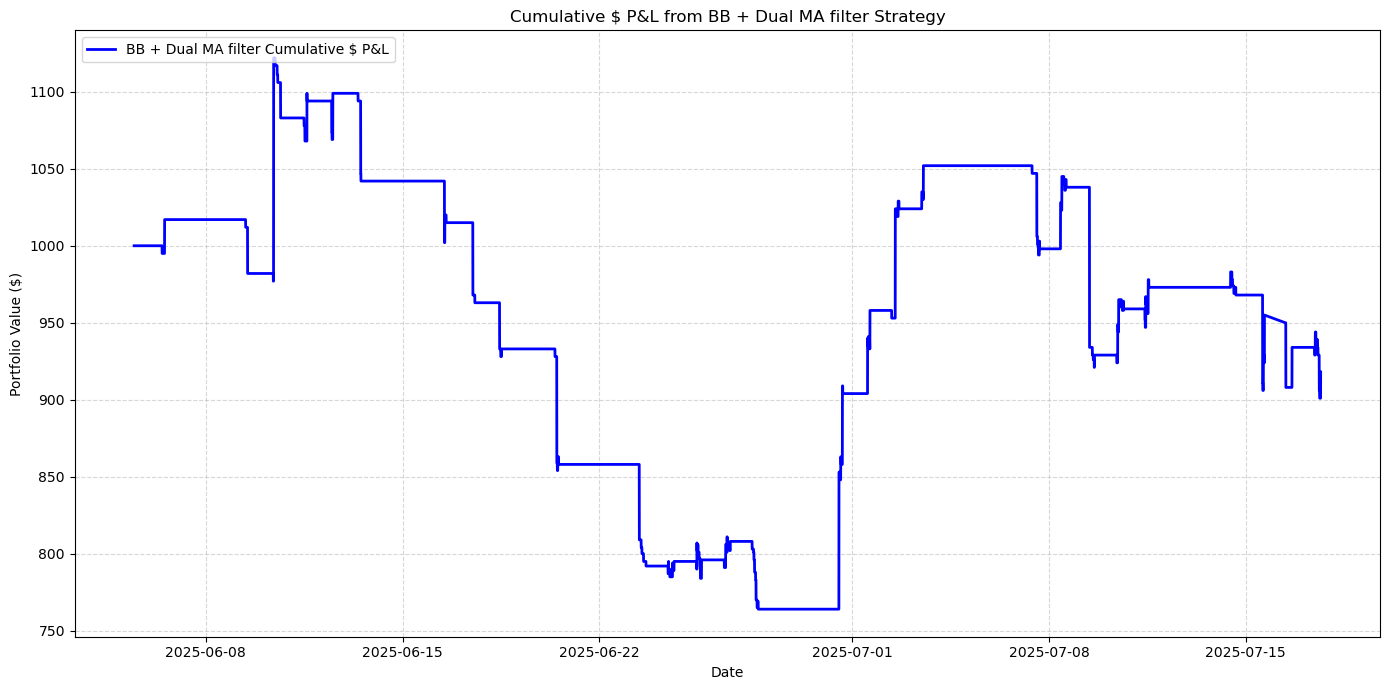


Long Trades: 43, Avg Return: -0.14, % Correct: 46.51%, % Incorrect: 53.49%
Short Trades: 36, Avg Return: -2.11, % Correct: 58.33%, % Incorrect: 41.67%


In [1]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# --- PARAMETERS ---
numbars = 14400
durationStr = '7 D'
barSizeSetting = '1 min'
symbol1 = 'GOOG'
lastTradeDateOrContractMonth1 = '20250725'
strike1 = 180
right1 = 'C'
symbol2 = symbol1
lastTradeDateOrContractMonth2 = lastTradeDateOrContractMonth1
strike2 = 190
right2 = right1
window = 20
num_std = 2

# --- FETCH FUNCTION ---
async def fetch_option(symbol, lastTradeDateOrContractMonth, strike, right, num_bars):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=np.random.randint(1000, 10000))
    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)
    all_bars = []
    end_time = ''
    while len(all_bars) < num_bars:
        bars = await ib.reqHistoricalDataAsync(
            contract=option_contract,
            endDateTime=end_time,
            durationStr=durationStr,
            barSizeSetting=barSizeSetting,
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        if not bars:
            print("No more bars available.")
            break
        all_bars = bars + all_bars
        end_time = (bars[0].date - pd.Timedelta(minutes=1)).strftime('%Y%m%d %H:%M:%S')
        await asyncio.sleep(1)
    all_bars = all_bars[-num_bars:]
    df = util.df(all_bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'close': 'Close'}, inplace=True)
    ib.disconnect()
    return df

# --- MAIN LOGIC ---
async def main():
    # Fetch option close prices
    datafix = await fetch_option(symbol1, lastTradeDateOrContractMonth1, strike1, right1, numbars)
    datafix2 = await fetch_option(symbol2, lastTradeDateOrContractMonth2, strike2, right2, numbars)
    datafix.index = datafix.index.tz_localize(None)
    datafix2.index = datafix2.index.tz_localize(None)

    # Calculate spread
    datafix["spread"] = datafix["Close"] - datafix2["Close"]

    # Calculate Bollinger Bands on Spread
    datafix['bb_middle'] = datafix['spread'].rolling(window=window).mean()
    datafix['bb_std'] = datafix['spread'].rolling(window=window).std()
    datafix['bb_upper'] = datafix['bb_middle'] + num_std * datafix['bb_std']
    datafix['bb_lower'] = datafix['bb_middle'] - num_std * datafix['bb_std']

    # Dual moving averages
    datafix['sma_20'] = datafix['spread'].rolling(window=20).mean()
    datafix['sma_50'] = datafix['spread'].rolling(window=50).mean()

    # Generate Buy/Sell/Hold Signals based on BB and dual MA regime
    datafix['prev_spread'] = datafix['spread'].shift(1)
    datafix['prev_bb_lower'] = datafix['bb_lower'].shift(1)
    datafix['prev_bb_upper'] = datafix['bb_upper'].shift(1)

    bb_buy = (datafix['prev_spread'] > datafix['prev_bb_lower']) & (datafix['spread'] < datafix['bb_lower'])
    bb_sell = (datafix['prev_spread'] < datafix['prev_bb_upper']) & (datafix['spread'] > datafix['bb_upper'])

    # Dual MA regime filter
    buy_mask = bb_buy & (datafix['sma_20'] > datafix['sma_50'])
    sell_mask = bb_sell & (datafix['sma_20'] < datafix['sma_50'])

    datafix['bb_signal'] = 'hold'
    datafix.loc[buy_mask, 'bb_signal'] = 'buy'
    datafix.loc[sell_mask, 'bb_signal'] = 'sell'

    # --- Backtest with Delayed Entry/Exit (next close) and Single Position ---
    initial_capital = 1000
    capital = initial_capital
    position = 0  # 1 for long, -1 for short, 0 for flat
    positions = []
    portfolio = []
    entry_spread = None
    fee = 5  # dollar fee per trade

    pending_entry = None  # 'long', 'short', or None
    pending_exit = False  # True if we need to close on next bar

    for i, (dt, row) in enumerate(datafix.iterrows()):
        sig = row['bb_signal']
        spread = row['spread']

        # Execute pending exit if any
        if pending_exit:
            if position == 1:  # close long
                pnl = (spread - entry_spread) * 100
                capital += pnl
                capital -= fee
                position = 0
                entry_spread = None
            elif position == -1:  # close short
                pnl = (entry_spread - spread) * 100
                capital += pnl
                capital -= fee
                position = 0
                entry_spread = None
            pending_exit = False

        # Execute pending entry if any
        if pending_entry is not None and position == 0:
            if pending_entry == 'long':
                position = 1
                entry_spread = spread
                capital -= fee
            elif pending_entry == 'short':
                position = -1
                entry_spread = spread
                capital -= fee
            pending_entry = None

        # Set pending exit/entry based on current signal
        if position == 0:
            if sig == 'buy':
                pending_entry = 'long'
            elif sig == 'sell':
                pending_entry = 'short'
        elif position == 1 and sig == 'sell':
            pending_exit = True
        elif position == -1 and sig == 'buy':
            pending_exit = True

        portfolio.append(capital)
        positions.append(position)

    datafix['BB_Position'] = positions
    datafix['BB_Portfolio'] = portfolio

    total_return = datafix['BB_Portfolio'].iloc[-1] - initial_capital
    print(f"Total Strategy $ Return (Bollinger Bands + Dual MA filter): ${total_return:.2f}")

    # Plot spread, BBs, signals and both MAs
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix["spread"],
        mode='lines', name='Spread', line=dict(color='black', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_upper'],
        mode='lines', name='BB Upper', line=dict(color='green', dash='dash')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_lower'],
        mode='lines', name='BB Lower', line=dict(color='red', dash='dash')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['bb_middle'],
        mode='lines', name='BB Middle', line=dict(color='orange', dash='dot')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['sma_20'],
        mode='lines', name='SMA 20', line=dict(color='blue', dash='dot')
    ))
    fig.add_trace(go.Scatter(
        x=datafix.index, y=datafix['sma_50'],
        mode='lines', name='SMA 50', line=dict(color='purple', dash='dot')
    ))
    buy_signals = datafix[datafix["bb_signal"] == "buy"]
    fig.add_trace(go.Scatter(
        x=buy_signals.index, y=buy_signals["spread"],
        mode='markers', name='Buy (on spread)',
        marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
    ))
    sell_signals = datafix[datafix["bb_signal"] == "sell"]
    fig.add_trace(go.Scatter(
        x=sell_signals.index, y=sell_signals["spread"],
        mode='markers', name='Sell (on spread)',
        marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
    ))
    fig.update_layout(
        title="Spread, Bollinger Bands, Dual MA Regime Filter and Buy/Sell Signals",
        xaxis_title="Date",
        yaxis_title="Spread",
        legend=dict(x=0.01, y=0.99),
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=500
    )
    fig.show()

    # Plot cumulative P&L
    plt.figure(figsize=(14, 7))
    plt.plot(datafix.index, datafix['BB_Portfolio'], label='BB + Dual MA filter Cumulative $ P&L', color='blue', linewidth=2)
    plt.title('Cumulative $ P&L from BB + Dual MA filter Strategy')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Trade Performance Metrics: Match Pending Entry/Exit Logic ---
    trades = []
    entry_spread = None
    entry_idx = None
    pending_entry = None
    pending_exit = False
    position = 0  
    fee_stats = 5

    for i, (dt, row) in enumerate(datafix.iterrows()):
        sig = row['bb_signal']
        spread = row['spread']

        # Execute pending exit if any
        if pending_exit:
            if position == 1:  # close long
                ret = (spread - entry_spread) * 100 - 2 * fee_stats
                trades.append({'type': 'long', 'entry_idx': entry_idx, 'exit_idx': i, 'ret': ret})
                position = 0
                entry_spread = None
                entry_idx = None
            elif position == -1:  # close short
                ret = (entry_spread - spread) * 100 - 2 * fee_stats
                trades.append({'type': 'short', 'entry_idx': entry_idx, 'exit_idx': i, 'ret': ret})
                position = 0
                entry_spread = None
                entry_idx = None
            pending_exit = False

        # Execute pending entry if any
        if pending_entry is not None and position == 0:
            if pending_entry == 'long':
                position = 1
                entry_spread = spread
                entry_idx = i
            elif pending_entry == 'short':
                position = -1
                entry_spread = spread
                entry_idx = i
            pending_entry = None

        # Set pending exit/entry based on current signal
        if position == 0:
            if sig == 'buy':
                pending_entry = 'long'
            elif sig == 'sell':
                pending_entry = 'short'
        elif position == 1 and sig == 'sell':
            pending_exit = True
        elif position == -1 and sig == 'buy':
            pending_exit = True

    trades_df = pd.DataFrame(trades)

    # Long trades
    long_trades = trades_df[trades_df['type'] == 'long']
    n_long = len(long_trades)
    n_long_win = (long_trades['ret'] > 0).sum()
    n_long_loss = (long_trades['ret'] <= 0).sum()
    avg_long_return = long_trades['ret'].mean() if n_long > 0 else np.nan
    pct_long_win = 100 * n_long_win / n_long if n_long > 0 else np.nan
    pct_long_loss = 100 * n_long_loss / n_long if n_long > 0 else np.nan

    # Short trades
    short_trades = trades_df[trades_df['type'] == 'short']
    n_short = len(short_trades)
    n_short_win = (short_trades['ret'] > 0).sum()
    n_short_loss = (short_trades['ret'] <= 0).sum()
    avg_short_return = short_trades['ret'].mean() if n_short > 0 else np.nan
    pct_short_win = 100 * n_short_win / n_short if n_short > 0 else np.nan
    pct_short_loss = 100 * n_short_loss / n_short if n_short > 0 else np.nan

    print(f"\nLong Trades: {n_long}, Avg Return: {avg_long_return:.2f}, % Correct: {pct_long_win:.2f}%, % Incorrect: {pct_long_loss:.2f}%")
    print(f"Short Trades: {n_short}, Avg Return: {avg_short_return:.2f}, % Correct: {pct_short_win:.2f}%, % Incorrect: {pct_short_loss:.2f}%")

    # Return for inspection if needed
    return datafix[['Close', 'spread', 'bb_upper', 'bb_lower', 'bb_middle', 'sma_20', 'sma_50', 'bb_signal', 'BB_Portfolio']]

# --- Run everything ---
datafix_summary = asyncio.run(main())
datafix = datafix_summary


In [2]:


from statsmodels.tsa.stattools import adfuller

# Assuming your DataFrame is named datafix and has a 'spread' column
spread_series = datafix['spread'].dropna()

# Run the ADF test
adf_result = adfuller(spread_series)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

if adf_result[1] < 0.05:
    print("Result: The spread is likely stationary (reject H0).")
else:
    print("Result: The spread is likely non-stationary (fail to reject H0).")


ADF Statistic: -2.272936
p-value: 0.180845
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Result: The spread is likely non-stationary (fail to reject H0).


In [3]:
import plotly.graph_objects as go

# --- Function to fetch latest N bars for each option ---
async def fetch_new_bars(symbol, lastTradeDateOrContractMonth, strike, right, n_bars=1):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=np.random.randint(1000, 10000))
    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)
    bars = await ib.reqHistoricalDataAsync(
        contract=option_contract,
        endDateTime='',
        durationStr=f'{n_bars} min',
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    ib.disconnect()
    if not bars:
        print(f"No new bars returned for {symbol} {strike} {right}.")
        return pd.DataFrame()
    df = util.df(bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'close': 'Close'}, inplace=True)  # Ensure 'Close' exists
    return df

# --- Function to update BB strategy with new data ---
def update_bb_strategy(datafix, datafix2, new_data1, new_data2, window=20, num_std=2):
    # Append new data if not already present
    datafix = pd.concat([datafix, new_data1[~new_data1.index.isin(datafix.index)]])
    datafix2 = pd.concat([datafix2, new_data2[~new_data2.index.isin(datafix2.index)]])
    datafix.index = datafix.index.tz_localize(None)
    datafix2.index = datafix2.index.tz_localize(None)
    # Update spread
    datafix["spread"] = datafix["Close"] - datafix2["Close"]
    # Update Bollinger Bands (only recalc for last window+1 rows for speed)
    recent = datafix.tail(window+1).copy()
    recent['bb_middle'] = recent['spread'].rolling(window=window).mean()
    recent['bb_std'] = recent['spread'].rolling(window=window).std()
    recent['bb_upper'] = recent['bb_middle'] + num_std * recent['bb_std']
    recent['bb_lower'] = recent['bb_middle'] - num_std * recent['bb_std']
    recent['prev_spread'] = recent['spread'].shift(1)
    recent['prev_bb_lower'] = recent['bb_lower'].shift(1)
    recent['prev_bb_upper'] = recent['bb_upper'].shift(1)
    buy_mask = (recent['prev_spread'] > recent['prev_bb_lower']) & (recent['spread'] < recent['bb_lower'])
    sell_mask = (recent['prev_spread'] < recent['prev_bb_upper']) & (recent['spread'] > recent['bb_upper'])
    recent['bb_signal'] = 'hold'
    recent.loc[buy_mask, 'bb_signal'] = 'buy'
    recent.loc[sell_mask, 'bb_signal'] = 'sell'
    datafix.update(recent)
    return datafix, datafix2

# --- Function to continue backtest from previous state ---
def continue_bb_backtest(datafix, initial_capital=1000, fee=1.50, multiplier=100):
    last_idx = datafix['BB_Portfolio'].last_valid_index()
    if last_idx is not None:
        capital = datafix.at[last_idx, 'BB_Portfolio']
        position = datafix.at[last_idx, 'BB_Position']
        if position == 1:
            entry_spread = datafix.loc[:last_idx][datafix['bb_signal'] == 'buy']['spread'].iloc[-1]
        else:
            entry_spread = None
        new_rows = datafix.loc[last_idx:].iloc[1:]
    else:
        capital = initial_capital
        position = 0
        entry_spread = None
        new_rows = datafix
    portfolio = []
    positions = []
    for idx, row in new_rows.iterrows():
        sig = row['bb_signal']
        spread = row['spread']
        if sig == 'buy' and position == 0:
            position = 1
            entry_spread = spread
            capital -= fee
        elif sig == 'sell' and position == 1:
            pnl = (spread - entry_spread) * multiplier
            capital += pnl
            capital -= fee
            position = 0
            entry_spread = None
        portfolio.append(capital)
        positions.append(position)
        datafix.at[idx, 'BB_Portfolio'] = capital
        datafix.at[idx, 'BB_Position'] = position
    return datafix

# --- Example usage: update with new data and plot ---
# Fetch new bars (example: 1 new bar)
new_data1 = await fetch_new_bars(symbol1, lastTradeDateOrContractMonth1, strike1, right1, n_bars=1)
new_data2 = await fetch_new_bars(symbol2, lastTradeDateOrContractMonth2, strike2, right2, n_bars=1)

# Update BB strategy DataFrame and backtest if we have new data
if not new_data1.empty and not new_data2.empty:
    datafix, datafix2 = update_bb_strategy(datafix, datafix2, new_data1, new_data2, window=20, num_std=2)
    datafix = continue_bb_backtest(datafix, initial_capital=1000, fee=1.50, multiplier=100)
    print("New bars found. Plotting latest data.")
else:
    print("No new bars found. Plotting last 30 bars of current datafix.")

# Always plot the last 30 bars (including new ones if present)
plot_df = datafix.tail(30)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=plot_df.index, y=plot_df["spread"],
    mode='lines', name='Spread', line=dict(color='black', width=2)
))
fig.add_trace(go.Scatter(
    x=plot_df.index, y=plot_df['bb_upper'],
    mode='lines', name='BB Upper', line=dict(color='green', dash='dash')
))
fig.add_trace(go.Scatter(
    x=plot_df.index, y=plot_df['bb_lower'],
    mode='lines', name='BB Lower', line=dict(color='red', dash='dash')
))
fig.add_trace(go.Scatter(
    x=plot_df.index, y=plot_df['bb_middle'],
    mode='lines', name='BB Middle', line=dict(color='orange', dash='dot')
))
buy_signals = plot_df[plot_df["bb_signal"] == "buy"]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=buy_signals["spread"],
    mode='markers', name='Buy (on spread)',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))
sell_signals = plot_df[plot_df["bb_signal"] == "sell"]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=sell_signals["spread"],
    mode='markers', name='Sell (on spread)',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))
fig.update_layout(
    title="Spread, Bollinger Bands, and Buy/Sell Signals (Last 30 Bars)",
    xaxis_title="Date",
    yaxis_title="Spread",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)
fig.show()


Error 321, reqId 4: Error validating request.-'bM' : cause - When specifying a unit, historical data request duration format is integer{SPACE}unit (S|D|W|M|Y)., contract: Option(conId=789542339, symbol='GOOG', lastTradeDateOrContractMonth='20250725', strike=180.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='GOOG  250725C00180000', tradingClass='GOOG')


No new bars returned for GOOG 180 C.


Error 321, reqId 4: Error validating request.-'bM' : cause - When specifying a unit, historical data request duration format is integer{SPACE}unit (S|D|W|M|Y)., contract: Option(conId=789542453, symbol='GOOG', lastTradeDateOrContractMonth='20250725', strike=190.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='GOOG  250725C00190000', tradingClass='GOOG')


No new bars returned for GOOG 190 C.
No new bars found. Plotting last 30 bars of current datafix.


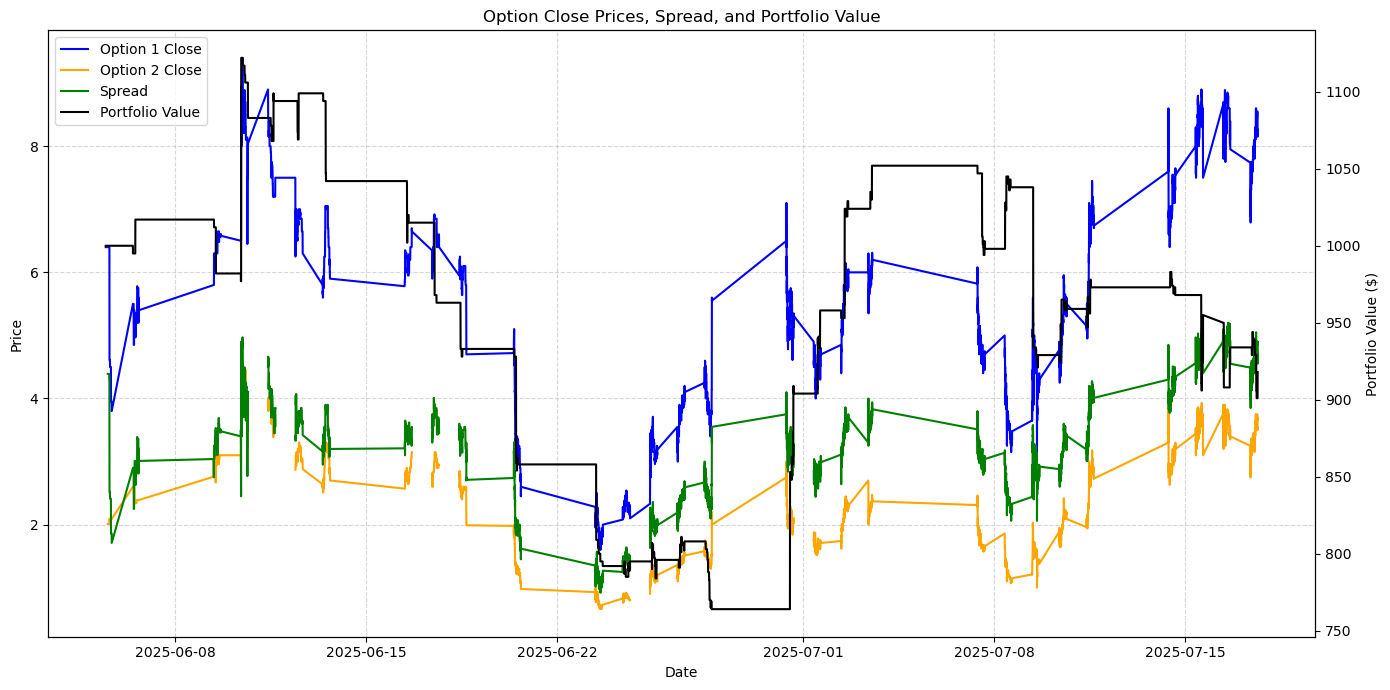

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Option 1 Close (Option 1)
ax1.plot(datafix.index, datafix['Close'], label='Option 1 Close', color='blue')
# Plot Option 2 Close (Option 2 = Option 1 Close - Spread)
ax1.plot(datafix.index, datafix['Close'] - datafix['spread'], label='Option 2 Close', color='orange')
# Plot Spread
ax1.plot(datafix.index, datafix['spread'], label='Spread', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis for portfolio returns (cumulative P&L)
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['BB_Portfolio'], label='Portfolio Value', color='black')
ax2.set_ylabel('Portfolio Value ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Option Close Prices, Spread, and Portfolio Value')
plt.tight_layout()
plt.show()
